In [1]:
import pickle
import torch
import copy
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchsummary

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=30
BATCH_SIZE=64
N_FOLDS = 2

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]))
        
        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [5]:
def create_dct_path_labels(train_val_files, train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_val_files, train_val_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [6]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)
print(len(train_val_files))

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])
print(len(train_val_files))

train_val_labels = [path.parent.name for path in train_val_files]
train_val_dataset = SimpsonsDataset(train_val_files, mode='val')

20933
21887


In [7]:
class SimpsonCNN(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        # 224
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 110
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop1 = nn.Dropout2d(p=0.25)
        # 54
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 26
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop2 = nn.Dropout2d(p=0.25)
        # 12
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 5        
        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.drop3 = nn.Dropout2d(p=0.25)
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.out = nn.Linear(1024, n_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data,gain=nn.init.calculate_gain('relu'))

    def forward(self, x):
        x = self.conv1(x)
        x = self.drop1(self.conv2(x))
        x = self.conv3(x)
        x = self.drop2(self.conv4(x))
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 256)
        x = self.drop3(self.fc1(x))        
        x = self.fc2(x)        
        logits = self.out(x)
        return logits

In [8]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        #opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #    opt, mode='max', factor=0.1, patience=10, verbose=False)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=6, gamma=0.1)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            #scheduler.step(val_acc)
            scheduler.step()
                
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [9]:
n_classes = len(np.unique(train_val_labels))
print(n_classes)
clf = SimpsonCNN(n_classes).to(DEVICE)
#clf = ConvModel(n_classes).to(DEVICE)
#print(clf)
torchsummary.summary(clf.cuda(), (3, RESCALE_SIZE, RESCALE_SIZE))


42
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 220, 220]           2,432
              ReLU-2         [-1, 32, 220, 220]               0
         MaxPool2d-3         [-1, 32, 110, 110]               0
            Conv2d-4         [-1, 32, 108, 108]           9,248
              ReLU-5         [-1, 32, 108, 108]               0
         MaxPool2d-6           [-1, 32, 54, 54]               0
         Dropout2d-7           [-1, 32, 54, 54]               0
            Conv2d-8           [-1, 64, 52, 52]          18,496
              ReLU-9           [-1, 64, 52, 52]               0
        MaxPool2d-10           [-1, 64, 26, 26]               0
           Conv2d-11          [-1, 128, 24, 24]          73,856
             ReLU-12          [-1, 128, 24, 24]               0
        MaxPool2d-13          [-1, 128, 12, 12]               0
        Dropout2d-14          [-1, 1

In [10]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [11]:
submit = pd.DataFrame(columns=['Id'])

epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


FOLD 1
loss 3.093012380913713


epoch:   3%|██▌                                                                         | 1/30 [01:11<34:41, 71.79s/it]


Epoch 001 train_loss: 3.0930     val_loss 2.7041 train_acc 0.2057 val_acc 0.2809
loss 2.4693535823747075


epoch:   7%|█████                                                                       | 2/30 [02:22<33:21, 71.49s/it]


Epoch 002 train_loss: 2.4694     val_loss 2.2288 train_acc 0.3208 val_acc 0.3923
loss 1.9596028002548358


epoch:  10%|███████▌                                                                    | 3/30 [03:33<32:07, 71.38s/it]


Epoch 003 train_loss: 1.9596     val_loss 1.8342 train_acc 0.4557 val_acc 0.4840
loss 1.5119772471360202


epoch:  13%|██████████▏                                                                 | 4/30 [04:44<30:52, 71.25s/it]


Epoch 004 train_loss: 1.5120     val_loss 1.4348 train_acc 0.5761 val_acc 0.6076
loss 1.152363264494248


epoch:  17%|████████████▋                                                               | 5/30 [05:57<29:52, 71.70s/it]


Epoch 005 train_loss: 1.1524     val_loss 1.1668 train_acc 0.6674 val_acc 0.6813
loss 0.8770643229361678


epoch:  20%|███████████████▏                                                            | 6/30 [07:11<28:58, 72.42s/it]


Epoch 006 train_loss: 0.8771     val_loss 1.0255 train_acc 0.7434 val_acc 0.7156
loss 0.5013601906331401


epoch:  23%|█████████████████▋                                                          | 7/30 [08:22<27:35, 71.97s/it]


Epoch 007 train_loss: 0.5014     val_loss 0.8252 train_acc 0.8589 val_acc 0.7746
loss 0.40536854464949174


epoch:  27%|████████████████████▎                                                       | 8/30 [09:33<26:15, 71.62s/it]


Epoch 008 train_loss: 0.4054     val_loss 0.8274 train_acc 0.8837 val_acc 0.7838
loss 0.33630968854314697


epoch:  30%|██████████████████████▊                                                     | 9/30 [10:43<24:57, 71.32s/it]


Epoch 009 train_loss: 0.3363     val_loss 0.8037 train_acc 0.9050 val_acc 0.7958
loss 0.29496337834108705


epoch:  33%|█████████████████████████                                                  | 10/30 [11:52<23:29, 70.47s/it]


Epoch 010 train_loss: 0.2950     val_loss 0.8153 train_acc 0.9161 val_acc 0.7970
loss 0.24936570085392437


epoch:  37%|███████████████████████████▍                                               | 11/30 [13:00<22:07, 69.88s/it]


Epoch 011 train_loss: 0.2494     val_loss 0.8296 train_acc 0.9300 val_acc 0.8017
loss 0.21418750685354826


epoch:  40%|██████████████████████████████                                             | 12/30 [14:09<20:51, 69.55s/it]


Epoch 012 train_loss: 0.2142     val_loss 0.8130 train_acc 0.9416 val_acc 0.8091
loss 0.16790239815900218


epoch:  43%|████████████████████████████████▌                                          | 13/30 [15:17<19:35, 69.16s/it]


Epoch 013 train_loss: 0.1679     val_loss 0.8272 train_acc 0.9566 val_acc 0.8087
loss 0.1601183879386896


epoch:  47%|███████████████████████████████████                                        | 14/30 [16:26<18:22, 68.89s/it]


Epoch 014 train_loss: 0.1601     val_loss 0.8404 train_acc 0.9579 val_acc 0.8054
loss 0.1543340418710086


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [17:34<17:08, 68.60s/it]


Epoch 015 train_loss: 0.1543     val_loss 0.8386 train_acc 0.9602 val_acc 0.8099
loss 0.14827405526331267


epoch:  53%|████████████████████████████████████████                                   | 16/30 [18:42<16:00, 68.64s/it]


Epoch 016 train_loss: 0.1483     val_loss 0.8449 train_acc 0.9611 val_acc 0.8077
loss 0.14742278268527234


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [19:50<14:50, 68.47s/it]


Epoch 017 train_loss: 0.1474     val_loss 0.8457 train_acc 0.9621 val_acc 0.8077
loss 0.13948626434177713


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [20:58<13:40, 68.35s/it]


Epoch 018 train_loss: 0.1395     val_loss 0.8434 train_acc 0.9647 val_acc 0.8101
loss 0.13846823570525243


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [22:07<12:34, 68.55s/it]


Epoch 019 train_loss: 0.1385     val_loss 0.8477 train_acc 0.9656 val_acc 0.8099
loss 0.13551751520465283


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [23:15<11:23, 68.35s/it]


Epoch 020 train_loss: 0.1355     val_loss 0.8542 train_acc 0.9670 val_acc 0.8071
loss 0.13351207816542518


epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [24:28<10:26, 69.66s/it]


Epoch 021 train_loss: 0.1335     val_loss 0.8440 train_acc 0.9682 val_acc 0.8101
loss 0.1304008143835766


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [25:43<09:29, 71.16s/it]


Epoch 022 train_loss: 0.1304     val_loss 0.8428 train_acc 0.9680 val_acc 0.8107
loss 0.13810891927958058


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [26:55<08:21, 71.59s/it]


Epoch 023 train_loss: 0.1381     val_loss 0.8477 train_acc 0.9654 val_acc 0.8097
loss 0.13584279118715645


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [28:06<07:08, 71.40s/it]


Epoch 024 train_loss: 0.1358     val_loss 0.8445 train_acc 0.9645 val_acc 0.8135
loss 0.13575784697479165


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [29:20<06:00, 72.02s/it]


Epoch 025 train_loss: 0.1358     val_loss 0.8546 train_acc 0.9666 val_acc 0.8076
loss 0.1373273410862372


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [30:35<04:51, 72.91s/it]


Epoch 026 train_loss: 0.1373     val_loss 0.8480 train_acc 0.9651 val_acc 0.8112
loss 0.13238431632731196


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [31:46<03:37, 72.56s/it]


Epoch 027 train_loss: 0.1324     val_loss 0.8431 train_acc 0.9676 val_acc 0.8072
loss 0.13534677442614976


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [33:01<02:26, 73.21s/it]


Epoch 028 train_loss: 0.1353     val_loss 0.8478 train_acc 0.9666 val_acc 0.8080
loss 0.1326020485528762


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [34:17<01:13, 73.93s/it]


Epoch 029 train_loss: 0.1326     val_loss 0.8471 train_acc 0.9675 val_acc 0.8110
loss 0.131193329474681


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [35:33<00:00, 71.12s/it]


Epoch 030 train_loss: 0.1312     val_loss 0.8542 train_acc 0.9676 val_acc 0.8089


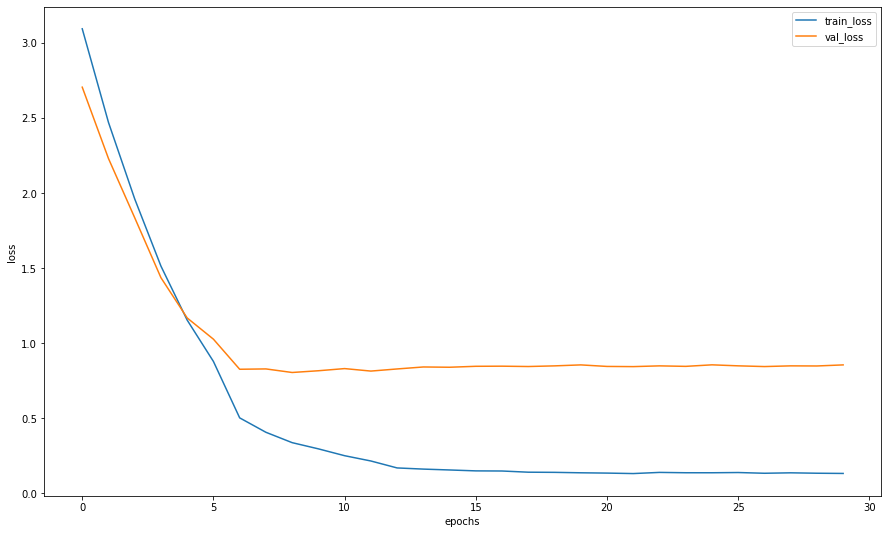

In [12]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    
    clf = SimpsonCNN(n_classes).to(DEVICE)
    history = train(train_dataset, val_dataset, model=clf, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(clf, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    
    submit[f'fold_{fold+1}'] = preds
    break

In [18]:
del clf, fold
torch.cuda.empty_cache()

NameError: name 'clf' is not defined

###  Submission

In [14]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit['Expected'] = submit.mode(axis=1)[0]
submit[['Id', 'Expected']].to_csv('submission_custom_kfold_adamw_lrs.csv', index=False)
submit.head()

,Id,fold_1,Expected
0,img0.jpg,nelson_muntz,img0.jpg
1,img1.jpg,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,img10.jpg
3,img100.jpg,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon
